<a href="https://colab.research.google.com/github/atharva-ketkar1/DemographicPredictor/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!unzip '/content/drive/MyDrive/Demographic Predictor Files/UTKFace.zip';

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: UTKFace/41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: UTKFace/58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: UTKFace/36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: UTKFace/25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: UTKFace/66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: UTKFace/40_0_1_20170117134411786.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._40_0_1_20170117134411786.jpg.chip.jpg  
  inflating: UTKFa

In [15]:
def data_generator(file_names, dataset_path, batch_size):
    while True:
        batch_images = []
        batch_age_labels = []
        batch_gender_labels = []
        batch_race_labels = []
        for file_name in file_names:
            parts = file_name.split('_')
            if len(parts) < 4:
                continue
            age = int(parts[0])
            gender = int(parts[1])
            race = int(parts[2])
            img_path = os.path.join(dataset_path, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128)) / 255.0
                batch_images.append(img)
                batch_age_labels.append(age)
                batch_gender_labels.append(gender)
                batch_race_labels.append(race)
            if len(batch_images) == batch_size:
                yield np.array(batch_images), {
                    'age_output': np.array(batch_age_labels),
                    'gender_output': np.array(batch_gender_labels),
                    'race_output': to_categorical(batch_race_labels, num_classes=5)
                }
                batch_images = []
                batch_age_labels = []
                batch_gender_labels = []
                batch_race_labels = []

In [16]:
dataset_path = 'UTKFace'
#dataset_path = '/content/drive/MyDrive/Demographic Predictor Files/UTKFace'
file_names = os.listdir(dataset_path)

# Split the file names into training and testing sets
train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)

# Set the batch size
batch_size = 32

# Create data generators for training and testing
train_generator = data_generator(train_files, dataset_path, batch_size)
test_generator = data_generator(test_files, dataset_path, batch_size)

In [ ]:
input_layer = Input(shape=(128, 128, 3))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# Fully connected layers for age prediction, dropout is added to try to prevent overfitting
dense_age = Dense(64, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Fully connected layers for gender prediction, dropout is added to try to prevent overfitting
dense_gender = Dense(64, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Fully connected layers for race prediction, dropout is added to try to prevent overfitting
dense_race = Dense(64, activation='relu')(flatten)
dropout_race = Dropout(0.3)(dense_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)

# Create the model
model = Model(inputs=input_layer, outputs=[output_age, output_gender, output_race])

# Compile the model
model.compile(optimizer='adam', loss={'age_output': 'mean_squared_error',
                                      'gender_output': 'binary_crossentropy',
                                      'race_output': 'categorical_crossentropy'},
              metrics={'age_output': 'mae',
                       'gender_output': 'accuracy',
                       'race_output': 'accuracy'})

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(test_files) // batch_size

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    epochs=50)

Epoch 1/50
592/592 [==============================] - 48s 63ms/step - loss: 388.1728 - age_output_loss: 385.9925 - gender_output_loss: 0.6944 - race_output_loss: 1.4861 - age_output_mae: 15.0111 - gender_output_accuracy: 0.5401 - race_output_accuracy: 0.4221 - val_loss: 233.5437 - val_age_output_loss: 231.5420 - val_gender_output_loss: 0.6156 - val_race_output_loss: 1.3861 - val_age_output_mae: 12.0177 - val_gender_output_accuracy: 0.7054 - val_race_output_accuracy: 0.4259
Epoch 2/50
592/592 [==============================] - 35s 59ms/step - loss: 217.2274 - age_output_loss: 215.2376 - gender_output_loss: 0.5945 - race_output_loss: 1.3954 - age_output_mae: 11.0735 - gender_output_accuracy: 0.6720 - race_output_accuracy: 0.4371 - val_loss: 177.6299 - val_age_output_loss: 175.8400 - val_gender_output_loss: 0.5240 - val_race_output_loss: 1.2659 - val_age_output_mae: 10.5158 - val_gender_output_accuracy: 0.7677 - val_race_output_accuracy: 0.5063
Epoch 3/50
592/592 [========================

In [ ]:
test_loss, test_age_loss, test_gender_loss, test_race_loss, test_age_mae, test_gender_accuracy, test_race_accuracy = model.evaluate(
    test_generator, steps=validation_steps)

print(f"Test Age MAE: {test_age_mae}")
print(f"Test Gender Accuracy: {test_gender_accuracy}")
print(f"Test Race Accuracy: {test_race_accuracy}")


148/148 [==============================] - 7s 49ms/step - loss: 97.0403 - age_output_loss: 95.8356 - gender_output_loss: 0.3320 - race_output_loss: 0.8728 - age_output_mae: 7.3400 - gender_output_accuracy: 0.8676 - race_output_accuracy: 0.7128
Test Age MAE: 7.339992046356201
Test Gender Accuracy: 0.8676097989082336
Test Race Accuracy: 0.712837815284729


In [ ]:
model.save('demographic_predictor_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('demographic_predictor_model.keras')


In [ ]:
from tensorflow.keras.models import load_model
print(t.__version__)

# Path to your saved model
model_path = '/content/drive/MyDrive/Demographic Predictor Files/demographic_predictor_model.keras'

# Load the model
model = load_model(model_path)

# Print the model summary to ensure it's loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [ ]:
## Second Implementation

In [5]:
import os
import re
checkpoint_dir = '/content/drive/MyDrive/colab_checkpoints'

# List all checkpoint files
checkpoint_files = os.listdir(checkpoint_dir)

# Sort checkpoint files by epoch number
checkpoint_files.sort(key=lambda x: int(re.findall(r'epoch(\d+)', x)[0]))

# Get the latest checkpoint file
latest_checkpoint = checkpoint_files[-1]
latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

print(f"Latest checkpoint file: {latest_checkpoint_path}")

Latest checkpoint file: /content/drive/MyDrive/colab_checkpoints/model-epoch50-val_loss72.40.h5


In [ ]:
def create_improved_model(input_shape):
    input_layer = Input(shape=input_shape)

    # First Convolutional Block
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
    norm1 = BatchNormalization()(conv1)
    max1 = MaxPooling2D(pool_size=(2, 2))(norm1)

    # Second Convolutional Block
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max1)
    norm2 = BatchNormalization()(conv2)
    max2 = MaxPooling2D(pool_size=(2, 2))(norm2)

    # Third Convolutional Block
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max2)
    norm3 = BatchNormalization()(conv3)
    max3 = MaxPooling2D(pool_size=(2, 2))(norm3)

    # Fourth Convolutional Block
    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max3)
    norm4 = BatchNormalization()(conv4)
    max4 = MaxPooling2D(pool_size=(2, 2))(norm4)

    # Flatten and Fully Connected Layers
    flatten = Flatten()(max4)

    # Fully connected layers for age prediction
    dense_age = Dense(256, activation='relu')(flatten)
    dropout_age = Dropout(0.5)(dense_age)
    dense_age2 = Dense(128, activation='relu')(dropout_age)
    dropout_age2 = Dropout(0.5)(dense_age2)
    output_age = Dense(1, activation='linear', name='age_output')(dropout_age2)

    # Fully connected layers for gender prediction
    dense_gender = Dense(256, activation='relu')(flatten)
    dropout_gender = Dropout(0.5)(dense_gender)
    dense_gender2 = Dense(128, activation='relu')(dropout_gender)
    dropout_gender2 = Dropout(0.5)(dense_gender2)
    output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender2)

    # Fully connected layers for race prediction
    dense_race = Dense(256, activation='relu')(flatten)
    dropout_race = Dropout(0.5)(dense_race)
    dense_race2 = Dense(128, activation='relu')(dropout_race)
    dropout_race2 = Dropout(0.5)(dense_race2)
    output_race = Dense(5, activation='softmax', name='race_output')(dropout_race2)

    model = Model(inputs=input_layer, outputs=[output_age, output_gender, output_race])

    return model

# Create the improved model
input_shape = (128, 128, 3)
#improved_model = create_improved_model(input_shape)
improved_model = load_model(latest_checkpoint_path)

# Compile the model
improved_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss={'age_output': 'mean_squared_error',
                             'gender_output': 'binary_crossentropy',
                             'race_output': 'categorical_crossentropy'},
                       metrics={'age_output': 'mae',
                                'gender_output': 'accuracy',
                                'race_output': 'accuracy'})

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)

checkpoint_dir = '/content/drive/MyDrive/colab_checkpoints'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + '/model-epoch{epoch:02d}-val_loss{val_loss:.2f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False,
    save_freq='epoch'
)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(test_files) // batch_size

# Train the model with callbacks
history = improved_model.fit(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=test_generator,
                             validation_steps=validation_steps,
                             epochs=50,
                             initial_epoch=int(re.findall(r'epoch(\d+)', latest_checkpoint)[0]),
                             callbacks=[early_stopping, lr_reducer, checkpoint_callback])

In [ ]:
test_loss, test_age_loss, test_gender_loss, test_race_loss, test_age_mae, test_gender_accuracy, test_race_accuracy = improved_model.evaluate(
    test_generator, steps=validation_steps)

print(f"Test Age MAE: {test_age_mae}")
print(f"Test Gender Accuracy: {test_gender_accuracy}")
print(f"Test Race Accuracy: {test_race_accuracy}")

148/148 [==============================] - 5s 33ms/step - loss: 72.3999 - age_output_loss: 71.8970 - gender_output_loss: 0.1238 - race_output_loss: 0.3790 - age_output_mae: 6.6578 - gender_output_accuracy: 0.9502 - race_output_accuracy: 0.8790
Test Age MAE: 6.657780647277832
Test Gender Accuracy: 0.9501689076423645
Test Race Accuracy: 0.8790118098258972


In [ ]:
improved_model.save('improved_model.h5')
improved_model.save('improved_model.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
print(tf.__version__)

In [6]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
import math

genders = {
    1: 'Female',
    0: 'Male'
}

def predict_demographics(image_path, model):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array /= 255.0

    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)

    predicted_age = round(pred[0][0][0])
    predicted_gender = genders[round(pred[1][0][0])]
    predicted_race = np.argmax(pred[2][0][0])

    race_labels = ['White', 'Black', 'Asian', 'Indian', 'Hispanic, Latino, Middle Eastern,etc']
    predicted_race_label = race_labels[predicted_race]

    plt.title(f'Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}, Predicted Race: {predicted_race_label}')
    plt.axis('off')
    plt.imshow(np.array(load_img(image_path)))
    plt.show()


test_model = load_model(latest_checkpoint_path)


1/1 [==============================] - 0s 419ms/step


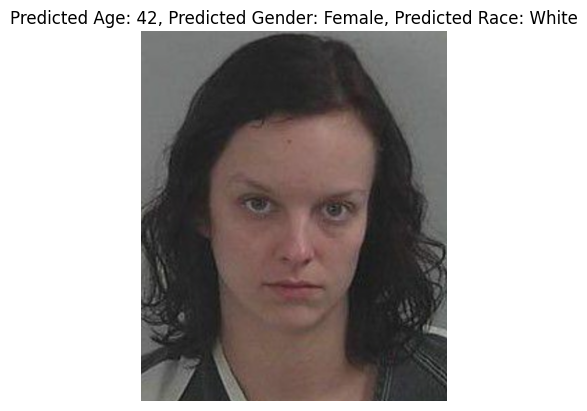

In [7]:
image_path = '/content/drive/MyDrive/Demographic Predictor Files/test_images/4.png'
predict_demographics(image_path, test_model)
#Off about 7 on her age

1/1 [==============================] - 0s 43ms/step


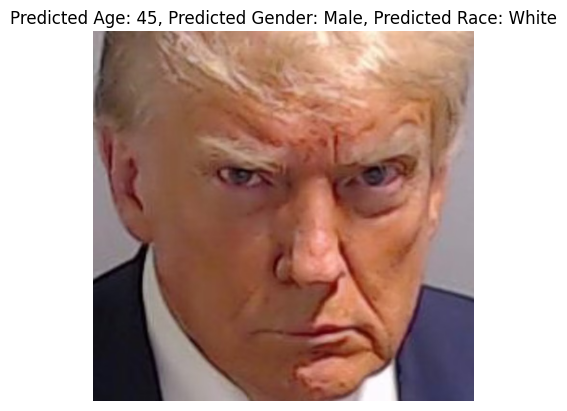

In [8]:
image_path = '/content/drive/MyDrive/Demographic Predictor Files/test_images/trump.png'
predict_demographics(image_path, test_model)
#Off about 30 on his age despite age mae being 6.6

1/1 [==============================] - 0s 31ms/step


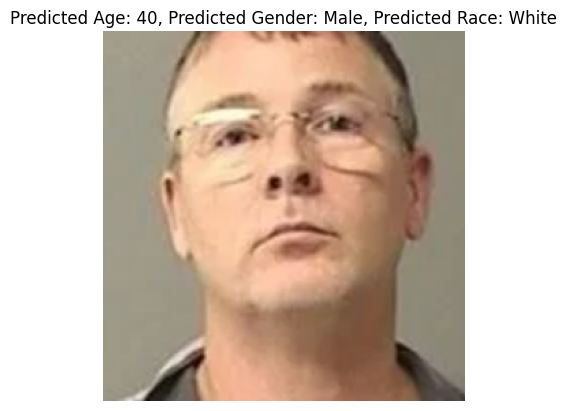

In [9]:
image_path = '/content/drive/MyDrive/Demographic Predictor Files/test_images/1.png'
predict_demographics(image_path, test_model)
#Pretty Good Estimation